<a href="https://colab.research.google.com/github/Avas77/email-spam-detection/blob/feature%2Fmodel-train/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries**



In [15]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import string
from pickle import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import warnings
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.text import TextCollection
warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **1. Data Loading**



In [2]:
emails_df = pd.read_csv('https://raw.githubusercontent.com/Avas77/Email-Spam-Detection-Using-NLP/refs/heads/main/dataset/emails.csv')

In [3]:
emails_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [5]:
emails_df.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## **2. Data Visualization**

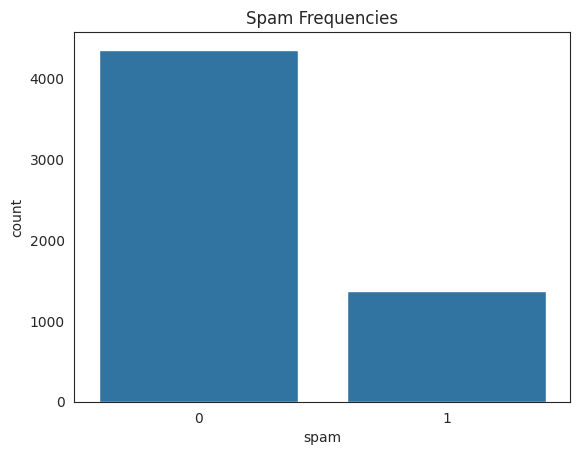

In [6]:
# visualize spam frequencies
plt.figure(dpi=100)
sns.countplot(x="spam", data=emails_df)
plt.title("Spam Frequencies")
plt.show()


## **3. Data Cleaning**

In [7]:
# Check for missing data for each column
emails_df.isnull().sum()

,0
text,0
spam,0


In [8]:
# Check for duplicates and remove them
emails_df.drop_duplicates(inplace=True)

In [9]:
def preprocess_text(text):
    # Remove "Subject:" from each text row
    text = re.sub(r"^subject:", "", text, flags=re.IGNORECASE).strip()
    wordnet_lemmatizer = WordNetLemmatizer()
    lowercase_sentence = text.lower()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(lowercase_sentence)
    processed = []
    for token in tokens:
        if token not in stop_words and token not in string.punctuation and token.isalpha():
            lemmatized = wordnet_lemmatizer.lemmatize(token)
            processed.append(lemmatized)
    return processed

In [10]:
emails_df["preprocessed"] = emails_df["text"].apply(preprocess_text)
emails_df.head()

,text,spam,preprocessed
0,Subject: naturally irresistible your corporate...,1,"[naturally, irresistible, corporate, identity,..."
1,Subject: the stock trading gunslinger fanny i...,1,"[stock, trading, gunslinger, fanny, merrill, m..."
2,Subject: unbelievable new homes made easy im ...,1,"[unbelievable, new, home, made, easy, im, want..."
3,Subject: 4 color printing special request add...,1,"[color, printing, special, request, additional..."
4,"Subject: do not have money , get software cds ...",1,"[money, get, software, cd, software, compatibi..."


## **4. Feature Extration**

In [30]:
# Convert the list of words in 'preprocessed' column to a string format
emails_df['preprocessed_str'] = emails_df['preprocessed'].apply(lambda x: ' '.join(x))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF on the 'preprocessed_str' column
tfidf_matrix = tfidf_vectorizer.fit_transform(emails_df['preprocessed_str'])
tfidf_matrix

<5695x30933 sparse matrix of type '<class 'numpy.float64'>'
	with 484283 stored elements in Compressed Sparse Row format>

## **5. Data Splitting**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, emails_df['spam'], test_size=0.20, random_state=0)

## **6. The Model**

In [34]:
# Model creation
model = MultinomialNB()

In [36]:
# Model training
model.fit(X_train, y_train)

MultinomialNB()

In [37]:
# Model predictions on test set
y_pred = model.predict(X_test)

In [38]:
# Model Evaluation | Accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy * 100

90.6935908691835

In [39]:
# Model Evaluation | Classification report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.89      1.00      0.94       870\n           1       0.99      0.61      0.76       269\n\n    accuracy                           0.91      1139\n   macro avg       0.94      0.81      0.85      1139\nweighted avg       0.92      0.91      0.90      1139\n'

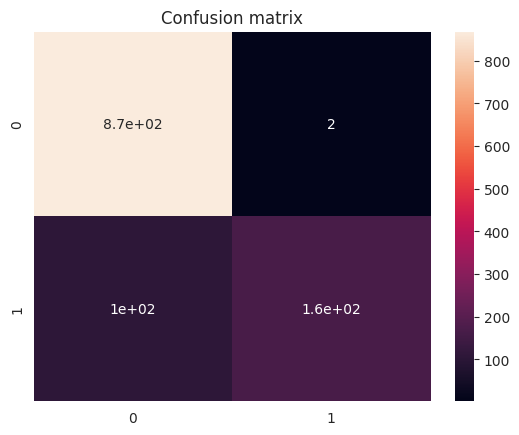

In [40]:
# Model Evaluation | Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(dpi=100)
sns.heatmap(cm, annot=True)
plt.title("Confusion matrix")
plt.show()